In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, json, random, math, os, sys

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, Lambda
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
file_name = ".SEED.txt"
with open(file_name, "r") as file:
    content = file.read().strip()  # Read and remove any extra whitespace/newlines
    number = int(content)  # Use float() to support decimal; use int() if it's always an integer

print("Seed:", number)
print("Type:", type(number))

Seed: 271828183
Type: <class 'int'>


In [3]:
# ---------------- User knobs ----------------
CSV_PATH   = "ALL_MERGED.csv"   # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # False to exclude TARGET from X
TEST_SIZE   = 0.20
VAL_SIZE    = 0.10
RANDOM_SEED = number
MAX_EPOCHS  = 100
VERBOSE_TRAIN = 1

# Random search settings
N_TRIALS   = 50                # bump to 40–60 for deeper search
PATIENCE   = 10
WEIGHTS_BEST = "Model Weights/rs_transformer_best.weights.h5"
MODEL_BEST   = "Model Checkpoints/transformer_rs_checkpoint.keras"

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

271828183


In [4]:
df = pd.read_csv(CSV_PATH)

required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


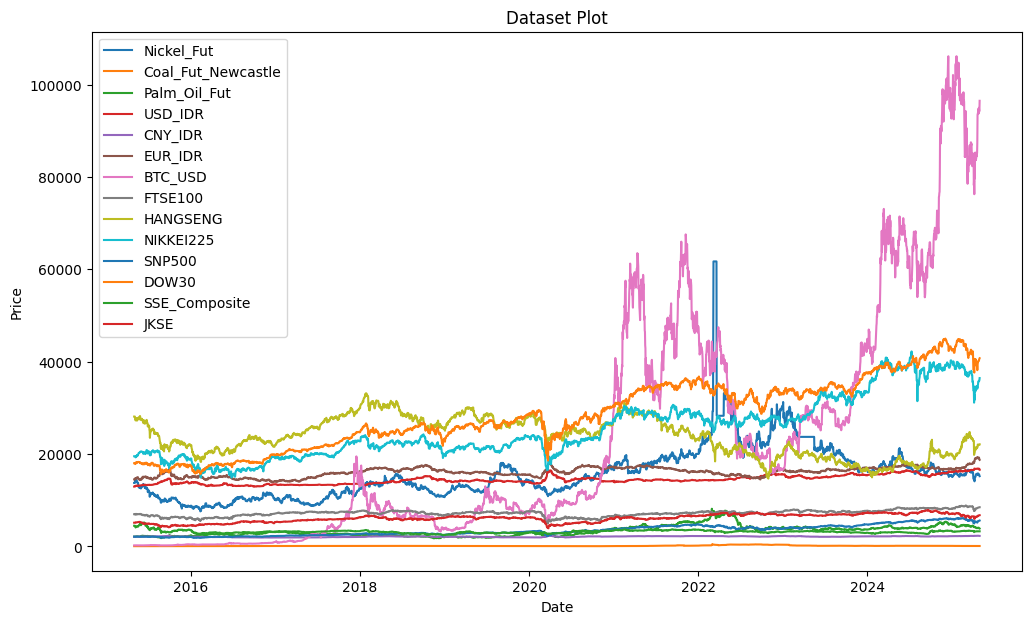

In [5]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [6]:
# ---------------- Split ----------------
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [7]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]
feature_cols

['Nickel_Fut',
 'Coal_Fut_Newcastle',
 'Palm_Oil_Fut',
 'USD_IDR',
 'CNY_IDR',
 'EUR_IDR',
 'BTC_USD',
 'FTSE100',
 'HANGSENG',
 'NIKKEI225',
 'SNP500',
 'DOW30',
 'SSE_Composite',
 'JKSE']

In [8]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [9]:
# ---------------- Utilities ----------------
def make_windows(X_df, y_df, lookback: int):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index
    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])  # predict t using t-lookback..t-1
        idx_list.append(idx[i])
    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

def positional_encoding(length, depth):
    # depth must be even for sin/cos pairing
    if depth % 2 != 0: depth += 1
    positions = np.arange(length)[:, np.newaxis]
    dims = np.arange(depth)[np.newaxis, :]
    angle_rates = 1.0 / (10000 ** (2 * (dims//2) / depth))
    angle_rads = positions * angle_rates
    pe = np.zeros((length, depth), dtype=np.float32)
    pe[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pe[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.constant(pe)

class AddPE(tf.keras.layers.Layer):
    def __init__(self, lookback, d_model, **kwargs):
        super().__init__(**kwargs)
        self.lookback = lookback
        self.d_model = d_model
        self.pos = positional_encoding(lookback, d_model)
    def call(self, x):
        return x + self.pos

def encoder_block(x, num_heads, d_model, dff, dropout_rate):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)(
        x, x, use_causal_mask=True
    )
    x = Add()([x, Dropout(dropout_rate)(attn)])
    x = LayerNormalization(epsilon=1e-6)(x)

    ff = Dense(dff, activation="relu")(x)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(d_model)(ff)
    x = Add()([x, Dropout(dropout_rate)(ff)])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def build_transformer(input_shape, params):
    lb = params["lookback"]
    d_model = params["d_model"]
    num_heads = params["num_heads"]
    dff = params["dff"]
    dropout = params["dropout"]

    inp = Input(shape=input_shape)
    x = Dense(d_model)(inp)
    x = AddPE(lb, d_model)(x)

    for _ in range(params["num_layers"]):
        x = encoder_block(
            x,
            num_heads=num_heads,
            d_model=d_model,
            dff=dff,
            dropout_rate=dropout
        )

    x = Lambda(lambda t: t[:, -1, :])(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)

    # Optuna always uses Adam
    opt = Adam(learning_rate=params["lr"])
    model.compile(optimizer=opt, loss="mse")

    return model

# Make sure d_model is divisible by num_heads
def sample_divisible_pair(d_model_choices, head_choices):
    for _ in range(50):
        dm = random.choice(d_model_choices)
        nh = random.choice(head_choices)
        if dm % nh == 0:
            return dm, nh
    # fallback
    return 64, 4

def sample_params():
    lookback = random.choice([30, 45, 60, 90])
    d_model = random.choice([32, 64, 96, 128])
    valid_heads = [h for h in (2, 4, 8) if d_model % h == 0 and d_model // h >= 8]
    num_heads = random.choice(valid_heads)
    dff = random.choice([2*d_model, 3*d_model, 4*d_model])

    params = {
        "lookback": lookback,
        "d_model": d_model,
        "num_heads": num_heads,
        "dff": dff,
        "num_layers": random.choice([1, 2, 3]),
        "dropout": np.random.uniform(0.0, 0.3),
        "optimizer": "adam",
        "lr": 10 ** np.random.uniform(-4, math.log10(5e-3)),
        "batch_size": random.choice([32, 64, 128]),
        "epochs": random.choice([30, 40, 50, 60, 70, 80, 90, 100]),
        "patience": random.choice([5, 6, 7, 8, 9, 10])
    }

    return params

def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [10]:
# ---------------- Random Search ----------------
best = {"val_loss": np.inf, "params": None}

print("\n=== Random Search (Transformer) begins ===")
hpo_start = time.time()  # HPO timer starts
for t in range(1, N_TRIALS + 1):
    params = sample_params()

    # Build windows with this trial's lookback
    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, params["lookback"])
    X_vl, y_vl, _ = make_windows(X_val_s,   y_val_s,   params["lookback"])

    model = build_transformer((params["lookback"], len(feature_cols)), params)

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    ]

    start = time.time()
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_vl, y_vl),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=callbacks,
        verbose=0
    )
    dur = time.time() - start

    val_loss = float(min(hist.history["val_loss"]))
    print(f"[Trial {t:02d}] lb={params['lookback']}, layers={params['num_layers']}, "
          f"d_model={params['d_model']}, heads={params['num_heads']}, dff={params['dff']}, "
          f"drop={params['dropout']}, opt={params['optimizer']}, lr={params['lr']}, "
          f"bs={params['batch_size']}  => val_loss={val_loss:.6f} ({dur:.1f}s)")

    if val_loss < best["val_loss"]:
        best = {"val_loss": val_loss, "params": params}
        model.save_weights(WEIGHTS_BEST)
hpo_end = time.time()  # HPO timer ends
hpo_time_s = float(hpo_end - hpo_start)
hpo_trials = N_TRIALS

print("\nBest val_loss:", best["val_loss"])
print("Best params:\n", json.dumps(best["params"], indent=2))


=== Random Search (Transformer) begins ===

[Trial 01] lb=90, layers=3, d_model=32, heads=2, dff=128, drop=0.1716649385278118, opt=adam, lr=0.0006023757744019968, bs=32  => val_loss=0.026598 (138.9s)
[Trial 02] lb=60, layers=1, d_model=128, heads=4, dff=384, drop=0.2870528249083718, opt=adam, lr=0.000803924347200877, bs=64  => val_loss=0.013613 (28.4s)
[Trial 03] lb=30, layers=2, d_model=32, heads=2, dff=128, drop=0.25659499640621103, opt=adam, lr=0.001776050814586662, bs=32  => val_loss=0.016288 (36.9s)
[Trial 04] lb=90, layers=3, d_model=128, heads=4, dff=512, drop=0.02350016306073822, opt=adam, lr=0.0006585208640936544, bs=128  => val_loss=0.009563 (456.7s)
[Trial 05] lb=90, layers=3, d_model=128, heads=4, dff=256, drop=0.05065361246887718, opt=adam, lr=0.0023239105457533603, bs=32  => val_loss=0.008701 (139.7s)
[Trial 06] lb=45, layers=3, d_model=32, heads=2, dff=128, drop=0.25482016014943787, opt=adam, lr=0.00015184844950893856, bs=128  => val_loss=0.020124 (41.3s)
[Trial 07] lb=

In [11]:
# ---------------- Retrain best on TRAIN+VAL & Evaluate on TEST ----------------
lb = best["params"]["lookback"]
X_trainval_s = pd.concat([X_train_s, X_val_s], axis=0)
y_trainval_s = pd.concat([y_train_s, y_val_s], axis=0)

X_trv, y_trv, _ = make_windows(X_trainval_s, y_trainval_s, lb)
X_te,  y_te,  idx_te  = make_windows(X_test_s,      y_test_s,      lb)

best_model = build_transformer((lb, len(feature_cols)), best["params"])

callbacks_final = [
    EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(MODEL_BEST, monitor="val_loss", save_best_only=True),
    # ModelCheckpoint(WEIGHTS_BEST, monitor="val_loss", save_best_only=True, save_weights_only=True),
]

start_train = time.time()
hist_final = best_model.fit(
    X_trv, y_trv,
    validation_split=0.1,
    epochs=best["params"]["epochs"],
    batch_size=best["params"]["batch_size"],
    callbacks=callbacks_final,
    verbose=VERBOSE_TRAIN
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.2f} s")

Epoch 1/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - loss: 1.5820 - val_loss: 0.8121
Epoch 2/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 0.2968 - val_loss: 0.1015
Epoch 3/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.1918 - val_loss: 0.0512
Epoch 4/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.1546 - val_loss: 0.0356
Epoch 5/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.1318 - val_loss: 0.0337
Epoch 6/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.1075 - val_loss: 0.0424
Epoch 7/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.0889 - val_loss: 0.0285
Epoch 8/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 0.0762 - val_loss: 0.0409
Epoch 9/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - loss: 0.0730 - val_loss: 0.0230
Epoch 10/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0669 - val_loss: 0.0246
Epoch 11/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.0539 - val_loss: 0.0229
Epoch 12/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/ste

In [12]:
# Inference on test
start_test = time.time()
yhat_s = best_model.predict(X_te, verbose=1)
yhat   = y_scaler.inverse_transform(yhat_s).squeeze()
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} s")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Testing (inference) time: 1.0381 s


In [13]:
# Align & metrics
actual = df[TARGET_COL]
actual_test = actual.loc[idx_te]
pred_test   = pd.Series(yhat, index=idx_te, name="Pred")

mse  = mean_squared_error(actual_test.values, pred_test.values)
mae  = mean_absolute_error(actual_test.values, pred_test.values)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_test.values, pred_test.values)
r2   = r2_score(actual_test.values, pred_test.values)

metrics_df = pd.DataFrame(
    [[mse, mae, rmse, mape, r2]],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Test (best cfg)"]
)
pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics (Final Best Config, Transformer) ===")
print(metrics_df)


=== Metrics (Final Best Config, Transformer) ===
                       MSE      MAE     RMSE   MAPE     R²
Test (best cfg) 76440.5771 240.4978 276.4789 0.0334 0.3219


In [14]:
residuals = pd.Series(actual_test.values - pred_test.values, index=idx_te, name="Residuals")

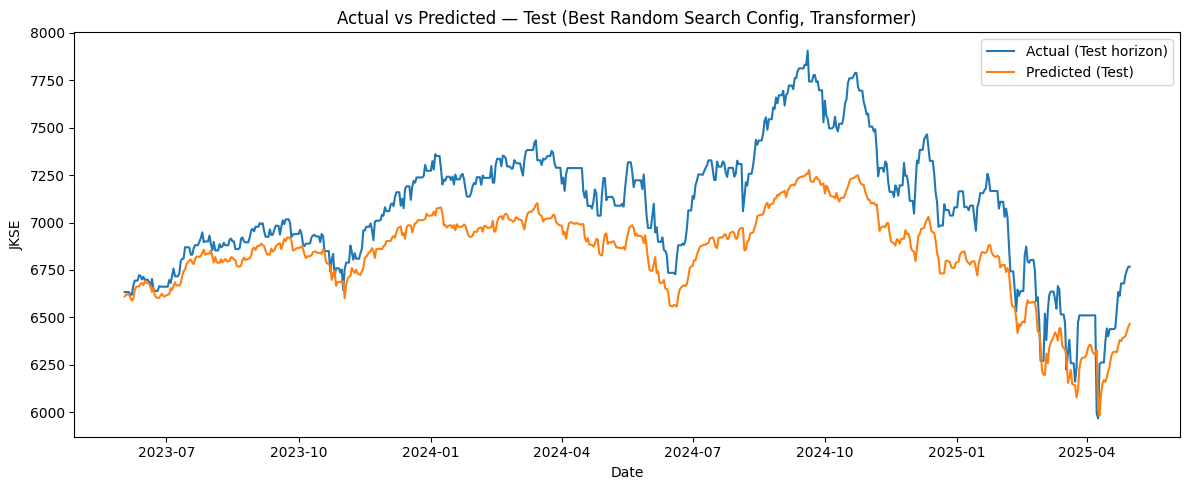

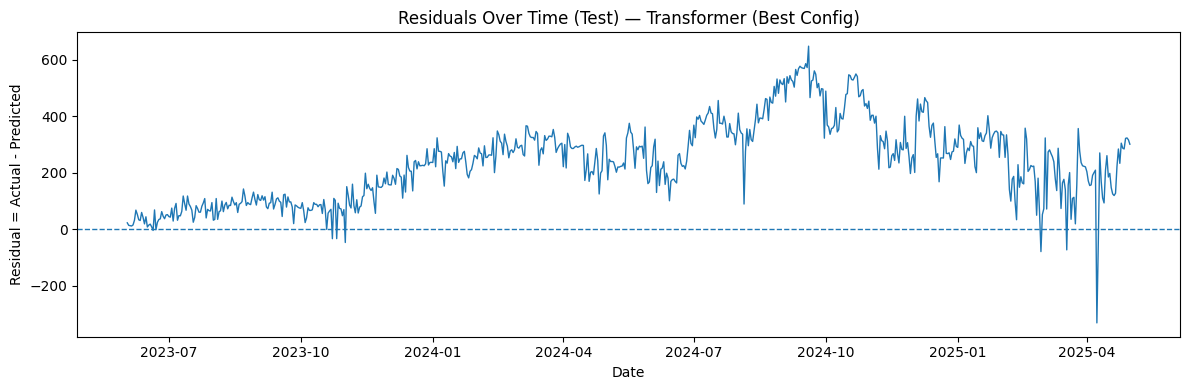

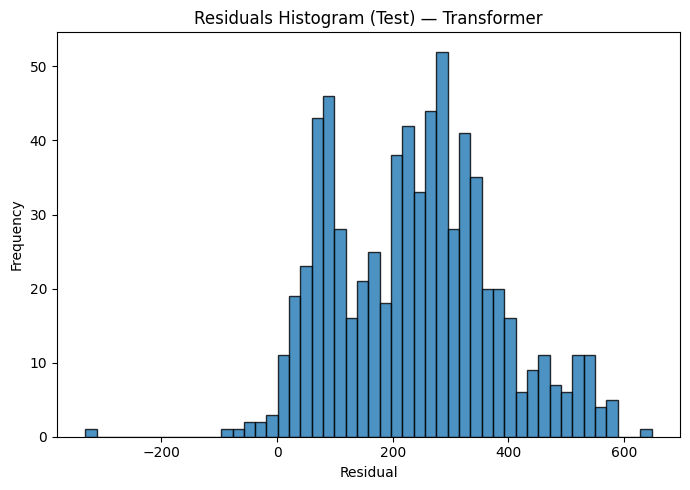

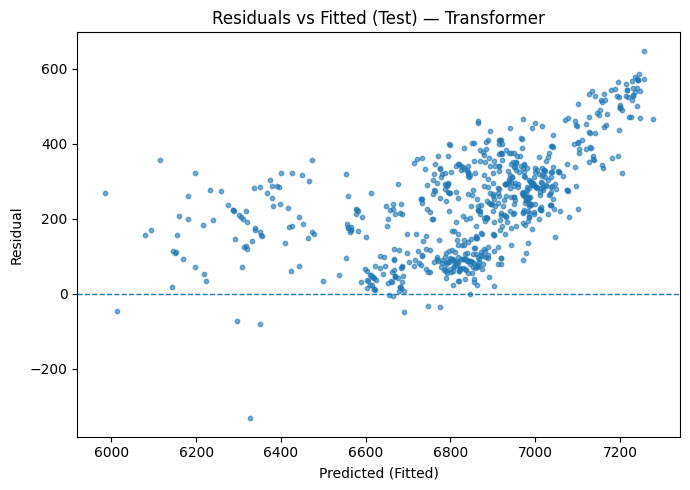

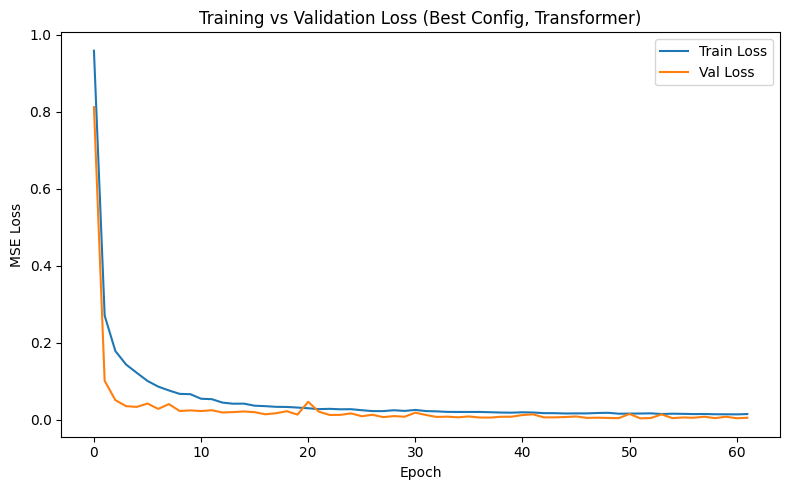

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test horizon)", linewidth=1.5)
plt.plot(pred_test.index,   pred_test.values,   label="Predicted (Test)", linewidth=1.5)
plt.title("Actual vs Predicted — Test (Best Random Search Config, Transformer)")
plt.xlabel("Date"); plt.ylabel(TARGET_COL)
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals.values, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time (Test) — Transformer (Best Config)")
plt.xlabel("Date"); plt.ylabel("Residual = Actual - Predicted")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7, 5))
plt.hist(residuals.values, bins=50, edgecolor="black", alpha=0.8)
plt.title("Residuals Histogram (Test) — Transformer")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(pred_test.values, residuals.values, s=10, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals vs Fitted (Test) — Transformer")
plt.xlabel("Predicted (Fitted)"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 5))
plt.plot(hist_final.history["loss"], label="Train Loss")
plt.plot(hist_final.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss (Best Config, Transformer)")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.tight_layout(); plt.show()

In [16]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "transformer_rs"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(pred_test.values, index=pd.to_datetime(idx_te), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
# mse, mae, rmse, mape, r2 = metrics_test
picp = mpiw = winkler = 0

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_test - start_test, 4),
    "hpo_trial_s": N_TRIALS,
    "hpo_time_s": round(hpo_end - hpo_start, 4),
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")

Model Name for Documentation: transformer_rs_271828183
✅ Predictions saved to ..\Results\ALL_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
